In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize
import random
from sklearn.preprocessing import StandardScaler



In [93]:
recipes_df = pd.read_csv("recipes_with_final_embeddings.csv")  
bert_embeddings = np.load("bert_embeddings.npz")
bert_embeddings = bert_embeddings['embeddings']
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]  

In [ ]:
class CustomAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CustomAutoencoder, self).__init__()
        self.input_noise = layers.GaussianNoise(0.1)  
        self.encoder_dense1 = layers.Dense(1024, activation='relu')
        self.encoder_dense2 = layers.Dense(512, activation='relu')
        self.encoder_latent = layers.Dense(latent_dim, activation='relu')
        self.latent_noise = layers.GaussianNoise(0.1)  
        self.decoder_dense1 = layers.Dense(512, activation='relu')
        self.decoder_dense2 = layers.Dense(1024, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        # Encoder
        x = self.input_noise(inputs)  
        x = self.encoder_dense1(x)
        skip = x  
        x = self.encoder_dense2(x)
        latent = self.encoder_latent(x)
        latent = self.latent_noise(latent)  
        latent = layers.add([latent, skip])  

        # Decoder
        x = self.decoder_dense1(latent)
        x = self.decoder_dense2(x)
        reconstruction = self.decoder_output(x)
        return reconstruction, latent


input_dim = normalized_embeddings.shape[1]
latent_dim = 1024
custom_autoencoder = CustomAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


Epoch 1/5


D:\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0445
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3811e-04
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Latent Space Embeddings for Recipes:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def clustering_loss(latent_embeddings, lambda_cluster=0.1):
    mean_embedding = tf.reduce_mean(latent_embeddings, axis=0)
    distances = tf.norm(latent_embeddings - mean_embedding, axis=1)
    cluster_penalty = tf.reduce_mean(distances)
    return lambda_cluster * cluster_penalty

def custom_combined_loss(y_true, y_pred, latent_embeddings, lambda_recon=1.0, lambda_cluster=0.5):
    recon_loss = reconstruction_loss(y_true, y_pred)
    cluster_loss = clustering_loss(latent_embeddings, lambda_cluster)
    return lambda_recon * recon_loss  + cluster_loss


In [96]:
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, latent_embeddings = custom_autoencoder(x_batch)
        loss = custom_combined_loss(x_batch, y_pred, latent_embeddings)
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [ ]:
history = {'loss': [], 'diversity': [], 'silhouette': [], 'davies_bouldin': []}

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

epochs = 20
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_embeddings).batch(batch_size)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()

        _, latent_embeddings = custom_autoencoder(x_batch)

    latent_embeddings = custom_autoencoder(normalized_embeddings)[1]
    kmeans = KMeans(n_clusters=5, random_state=42).fit(latent_embeddings)
    silhouette = silhouette_score(latent_embeddings, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(latent_embeddings, kmeans.labels_)

    avg_loss = epoch_loss / (step + 1)
    history['loss'].append(avg_loss)
    history['silhouette'].append(silhouette)
    history['davies_bouldin'].append(davies_bouldin)

    print(f"Loss: {avg_loss:.4f}, Silhouette: {silhouette:.4f}, DB Index: {davies_bouldin:.4f}")


Epoch 1/20
Loss: 3.9378, Diversity: 0.0211, Silhouette: 0.0811, DB Index: 5.0782
Epoch 2/20
Loss: 1.5716, Diversity: 0.0005, Silhouette: 0.1313, DB Index: 5.5062
Epoch 3/20
Loss: 1.2908, Diversity: 0.0000, Silhouette: 0.1423, DB Index: 4.7250
Epoch 4/20
Loss: 1.2324, Diversity: 0.0000, Silhouette: 0.1098, DB Index: 3.9113
Epoch 5/20
Loss: 1.2056, Diversity: 0.0000, Silhouette: 0.1677, DB Index: 2.5344
Epoch 6/20
Loss: 1.1850, Diversity: 0.0000, Silhouette: 0.3066, DB Index: 1.8517
Epoch 7/20
Loss: 1.1610, Diversity: 0.0000, Silhouette: 0.3747, DB Index: 1.4846
Epoch 8/20
Loss: 1.1328, Diversity: 0.0000, Silhouette: 0.3761, DB Index: 1.2604
Epoch 9/20
Loss: 1.1041, Diversity: 0.0000, Silhouette: 0.5106, DB Index: 1.0615
Epoch 10/20
Loss: 1.0838, Diversity: 0.0000, Silhouette: 0.1541, DB Index: 1.7824
Epoch 11/20
Loss: 1.2419, Diversity: 0.0000, Silhouette: 0.5136, DB Index: 0.8477
Epoch 12/20
Loss: 1.0651, Diversity: 0.0000, Silhouette: 0.6234, DB Index: 0.7525
Epoch 13/20
Loss: 1.0484,

In [98]:
reconstructions, latent_embeddings = custom_autoencoder(bert_embeddings)
mse = tf.reduce_mean(tf.square(bert_embeddings - reconstructions)).numpy()
print(f"Reconstruction MSE: {mse:.4f}")
from sklearn.metrics import silhouette_score, davies_bouldin_score
latent_embeddings_np = latent_embeddings.numpy()
silhouette = silhouette_score(latent_embeddings_np, KMeans(n_clusters=5).fit_predict(latent_embeddings_np))
davies_bouldin = davies_bouldin_score(latent_embeddings_np, KMeans(n_clusters=5).fit_predict(latent_embeddings_np))
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")


Reconstruction MSE: 0.2920
Silhouette Score: 0.0879
Davies-Bouldin Index: 2.7221


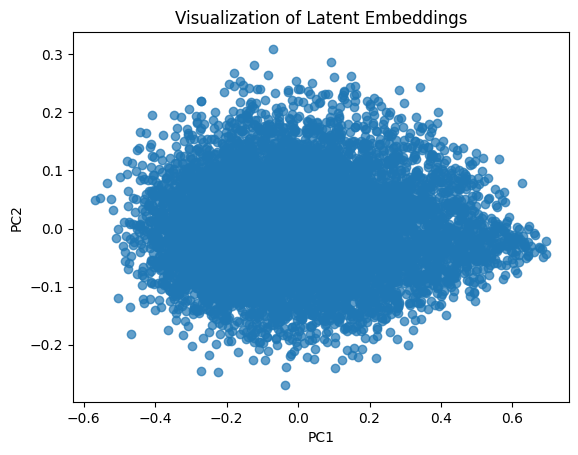

In [ ]:


pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_embeddings)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
plt.title("Latent Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
def display_liked_recipes(liked_recipes):
    """
    Display the liked recipes in a table.
    """
    print("Liked Recipes:")
    display(liked_recipes.reset_index(drop=True))  


liked_recipe_indices = [7, 20, 50]
liked_recipes = recipes_df.iloc[liked_recipe_indices][['title', 'categories', 'ingredients']]

display_liked_recipes(liked_recipes)


Liked Recipes:


,title,categories,ingredients
0,Raw Cream of Spinach Soup,"['Soup/Stew', 'Garlic', 'Onion', 'No-Cook', 'V...",['2 cups fresh tomato and/or carrot juice (fro...
1,"Baked Halibut with Orzo, Spinach, and Cherry T...","['Fish', 'Leafy Green', 'Pasta', 'Tomato', 'Ba...","['4 tablespoons extra-virgin olive oil, divide..."
2,Honey-Ginger Barbecue Sauce,"['Sauce', 'Garlic', 'Ginger', 'Side', 'Fourth ...","['1 1/2 cups apple cider vinegar', '1/2 cup mi..."


In [ ]:

recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)
recommended_recipes


Recommended Recipes:


,title,categories,ingredients
4938,"Grilled Leg of Lamb with Red Wine, Garlic, Mus...","['Garlic', 'Lamb', 'Mustard', 'Marinate', 'Low...","['1 cup dry red wine (such as Zinfandel)', '3/..."
1279,Anchovy Pasta With Garlic Breadcrumbs,"['Bon Appétit', 'Pasta', 'Dinner', 'Anchovy', ...","['8 garlic cloves, divided', '5 ounces sourdou..."
2959,Lemon Zucchini Vichyssoise,"['Soup/Stew', 'Milk/Cream', 'Blender', 'Potato...",['1 large leek (white and pale green parts onl...
2567,Orecchiette with Sausage and Red Pepper Sauce,"['Pasta', 'Pepper', 'Pork', 'Tomato', 'Gourmet']","['1 1/2 pounds sweet Italian sausage', '1 tabl..."
7235,Lamb Chops with Mushroom Wine Sauce,"['Lamb', 'Mushroom', 'Sauté', 'Quick & Easy', ...","['1 tablespoon olive oil', 'two 1/2-inch-thick..."


In [ ]:
def coverage(recommended_items, total_items):
    """
    Calculate coverage of recommendations.
    
    Parameters:
    - recommended_items: List of all recommended items across users.
    - total_items: Total number of unique items in the catalog.
    
    Returns:
    - Coverage score.
    """
    unique_recommended_items = set(recommended_items)
    return len(unique_recommended_items) / total_items
total_items = len(recipes_df)
recommended_items = recommended_recipes.index.tolist()
coverage_score = coverage(recommended_items, total_items)
print(f"Coverage: {coverage_score:.2f}")


Coverage: 0.00


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_recommendations(liked_recipe_indices, recommended_recipes, embeddings, top_n=5):
    """
    Evaluate recommendations by calculating:
    - Average similarity between liked and recommended recipes.
    - Diversity of recommended recipes.
    
    Parameters:
    - liked_recipe_indices: Indices of liked recipes.
    - recommended_recipes: DataFrame of recommended recipes.
    - embeddings: Latent embeddings of all recipes.
    - top_n: Number of recommendations.
    
    Returns:
    - Evaluation metrics: Average similarity, diversity.
    """
    liked_embeddings = embeddings[liked_recipe_indices]
    recommended_indices = recommended_recipes.index
    recommended_embeddings = embeddings[recommended_indices]
    similarities = cosine_similarity(liked_embeddings, recommended_embeddings)
    avg_similarity = np.mean(similarities)

    pairwise_similarities = cosine_similarity(recommended_embeddings)
    np.fill_diagonal(pairwise_similarities, 0)  
    diversity = 1 - np.mean(pairwise_similarities)
    
    return {
        "Average Similarity": avg_similarity,
        "Diversity": diversity
    }


evaluation_metrics = evaluate_recommendations(liked_recipe_indices, recommended_recipes, latent_embeddings)
print("Evaluation Metrics:")
print(evaluation_metrics)


Evaluation Metrics:
{'Average Similarity': 0.9999985, 'Diversity': 0.20000100135803223}
